In [12]:
import os
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import multiprocessing as mp
from tqdm import tqdm
from functools import partial
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets

In [13]:
def date_from_date_delta(n, date='2018-12-13'):
    date = pd.to_datetime(date)
    return (date + timedelta(days=int(n))).strftime('%Y-%m-%d')

def delta_from_date_date(date, date0='2018-12-13'):
    date0 = pd.to_datetime(date0)
    date = pd.to_datetime(date)
    return (date - date0).days

metadata = np.load('sent2_metadata.npy', allow_pickle=True)

valid_indexes = np.load('sent2_valid_image_index.npy').tolist()

data_directory = open('path_to_data.txt').read()
sent2_deforestation_segmentation = Dataset(os.path.join(data_directory, 'sent2_deforestation_segmentation.nc'))
sent2_b1_b4_train = Dataset(os.path.join(data_directory, 'sent2_b1-b4_train.nc'))

Original_sent2 = sent2_b1_b4_train
Additional_sent2 = sent2_deforestation_segmentation

# Coordinates
Original_COORDS = np.array(Original_sent2.variables['center_lat_lons']).T
Additional_COORDS = np.array(Additional_sent2.variables['center_lat_lons']).T
COORDS = np.concatenate((Original_COORDS, Additional_COORDS), axis=1)

# Dates
Original_DATES = np.array(Original_sent2.variables['collection_dates'])
Additional_DATES = np.array(Additional_sent2.variables['collection_dates'])
Combined_DATES_ARR = np.concatenate((Original_DATES, Additional_DATES), axis=0)
DATES = []
num_processes = mp.cpu_count()
print('Number of Processes:', num_processes)
pool = mp.Pool(processes=num_processes)
args = [(str(NUM)) for NUM in Combined_DATES_ARR]
partial_date_from_date_delta = partial(date_from_date_delta, date='2018-12-13')
for outputs in tqdm(pool.imap(partial_date_from_date_delta, args), total=len(args)):
    DATES.append(outputs)
    pass
pool.close()
pool.join()
DATES = np.array(DATES)

# Data Bands
Original_DATA_BANDS = np.array(Original_sent2.variables['data_band'])
Additional_DATA_BANDS = np.array(Additional_sent2.variables['data_band'])
Additional_DATA_BANDS_DICT = {Additional_DATA_BANDS[i] : i for i in range(Additional_DATA_BANDS.shape[0])}
DATA_BANDS = Original_DATA_BANDS

# Images
def get_image(idx):
    Original_num_images = Original_sent2.variables['images'].shape[0]
    Additional_num_images = Additional_sent2.variables['images'].shape[0]
    if idx < Original_num_images:
        return np.array(Original_sent2.variables['images'][idx])
    else:
        idx -= Original_num_images
        img = np.array(Additional_sent2.variables['images'][idx])
        img = img[[Additional_DATA_BANDS_DICT[band] for band in DATA_BANDS]]
        return img
    
def normalize_image(image):
    percentile = np.percentile(image, [5, 95])
    image = np.clip(image, percentile[0], percentile[1])
    image = (image - percentile[0]) / (percentile[1] - percentile[0])
    return image

Number of Processes: 12


100%|██████████| 427813/427813 [00:18<00:00, 23637.96it/s]


,QA60_CLOUD,RGB_MEAN,CV2_CLOUD,Index,Date,Coordinates,Is_Valid
0,33.154297,0.119942,54.800415,12327,2018-12-28,"(-4.37, -54.5)",No


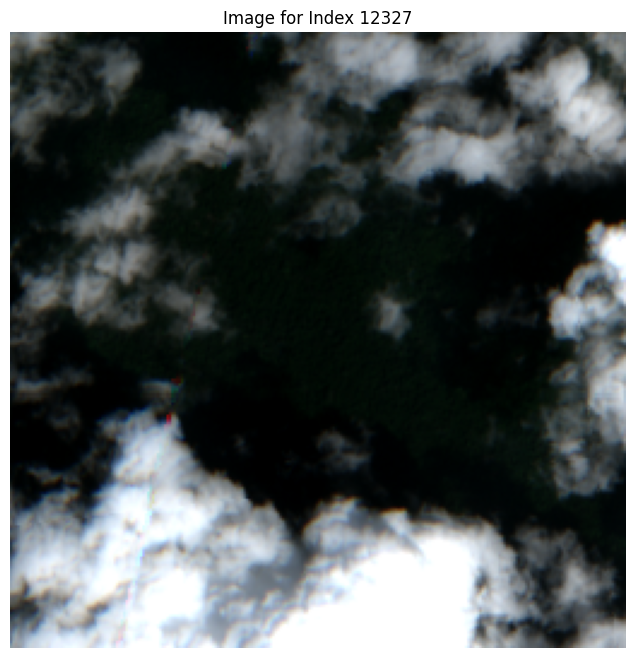

,QA60_CLOUD,RGB_MEAN,CV2_CLOUD,Index,Date,Coordinates,Is_Valid
0,100.0,0.495794,4.066467,12326,2018-12-23,"(-4.37, -54.5)",No


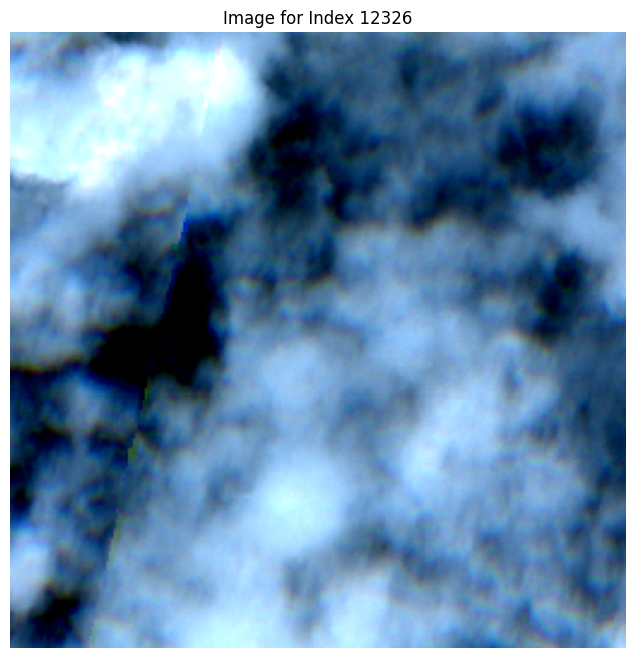

ValueError: invalid literal for int() with base 10: ''

In [14]:
def work(index):
    # Retrieve metadata
    QA60_CLOUD, RGB_MEAN, CV2_CLOUD = metadata[index]
    
    # Create metadata dictionary
    meta = {
        'QA60_CLOUD': QA60_CLOUD,
        'RGB_MEAN': RGB_MEAN,
        'CV2_CLOUD': CV2_CLOUD,
        'Index': index,
        'Date': DATES[index],
        'Coordinates': f'({COORDS[0, index]}, {COORDS[1, index]})',
        'Is_Valid': 'Yes' if index in valid_indexes else 'No'
    }
    
    # Convert to DataFrame for display
    meta_df = pd.DataFrame(meta, index=[0])
    display(meta_df)
    
    # Retrieve and normalize image
    image = normalize_image(get_image(index).squeeze()[1:4][::-1].transpose(1, 2, 0))
    
    # Display image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Image for Index {index}')
    plt.show()

while True:
    index = input("Enter an index: ")
    if index == 'exit':
        break
    work(int(index))